### first pass on API for ASE OOS

use cases:
- low/high degree nodes tend to distord spectral embedding, so omit from original embedding and then add back in with oos
- original graph too big, so make a subgraph and embed, then do oos for the rest
- have graph, embed it, get new graph defined on a larger set of nodes but with the same relationship between vertices. embed new graph with oos because it's generated by the same underlying distribution.

### notes
- add sklearn's exceptions.NotFittedError if we try to predict without fitting?
- for class-based sklearnish APIs, could add an augment_latent_positions toggle to predict if we want to have predicting update the latent positions matrix
- [partial-fit](https://scikit-learn.org/stable/glossary.html#term-partial-fit) could be useful if we want an API for updating our latent positions matrix with oos data?
- sklearn.utils.estimator_checks.check_estimator useful if I want to use the sklearn api
- sklearn.utils.check_array useful for input validation

In [14]:
import numpy as np
from sklearn.utils.validation import check_is_fitted

from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed
from graspy.embed.base import BaseEmbed

In [30]:
# API 1: we just have an OOSEmbedder class
class OOSEmbed(BaseEmbed):
    def __init__(self, Xhat=None):
        # maybe some useful toggles on behavior here?
        self.X_ = Xhat  # TODO: can pass in a precomputed ASE if you want,
                        # in which case `fit` will just use that as its X value.
                        # need some way to get eigenvalues if you pass in precomputed ASE
        pass
    
    def fit(self, X=None, y=None):
        """
        would take some input adjacency matrix X,
        embed it, and add self.pinv_, self.latent_right_,
        and self.singular_values_ to class attributes
        """
        # X \in R^{nxn}. if X is None, use `self.X`. If `self.X` is None, raise an error.
        
        # some code to make self.pinv,
        # input-validation
        # and maybe error checking, etc
        # returns self
        
        # checks on X go here, then
        # grab pinv and make new class attributes
        
        # TODO: break if X is None and self.X_ is None
        
        if self.X_ is None:
            ase = AdjacencySpectralEmbed(n_components=2)  # need some way to change parameters
            ase.fit(X)
            self.X_ = ase.latent_left_.copy()
            self.eig_values_ = ase.singular_values_.copy()
            
        self.pinv_ = self.X_ @ np.diag(1/self.eig_values_)
        
        self.is_fitted_ = True
        
        # add self.X_ \in R^{nxd}, the latent position matrix
        pass


    def predict(self, y):
        """
        Given some latent position matrix X,
        its diagonal eigenvalue matrix D,
        and edge matrix y,
        compute the least-squares estimate for the latent position of y.

        Parameters
        ----------
        y: array
            out-of-sample vectors to embed. nxd
        """
        check_is_fitted(self, 'is_fitted_')
        # input validation
        return y @ self.pinv_
        # maybe toggle for returning either 
        # *just* oos latent positions,
        # or an augmented ASE?

In [ ]:
from graspy.base import BaseEmbed

# API 2: we augment the AdjacencySpectralEmbed class with
# a predict method. This was Hayden's idea in the
# issue
class AdjacencySpectralEmbed(BaseEmbed):
    r"""
    bla bla bla
    """

    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        diag_aug=True,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            algorithm=algorithm,
            n_iter=n_iter,
            check_lcc=check_lcc,
        )

        if not isinstance(diag_aug, bool):
            raise TypeError("`diag_aug` must be of type bool")
        self.diag_aug = diag_aug

    def fit(self, graph, y=None):
        # would add the pseudoinverse
        # as a class attribute in fit
        """
        bla bla bla
        """
        A = import_graph(graph)

        if self.check_lcc:
            if not is_fully_connected(A):
                msg = (
                    "Input graph is not fully connected. Results may not"
                    + "be optimal. You can compute the largest connected component by"
                    + "using ``graspy.utils.get_lcc``."
                )
                warnings.warn(msg, UserWarning)

        if self.diag_aug:
            A = augment_diagonal(A)

        self._reduce_dim(A)
        return self
    
    def _fit_transform(self):
        # would return embedded latent position
        # matrix, and add it as a class attribute.
        # overwrites the super() fit_transform
        pass
    
    def transform(self):
        # check that fit has been called first
        return y @ self.pinv

## check true latent position compared to oos embedding as n increases

#### make matrix

In [49]:
from graspy.simulations import er_np
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

p = .5
distances = {}
for n in tqdm(range(10, 1000)):
    M = er_np(n=n, p=p)

    # separate
    A = M[:-1, :-1]
    a = M[-1, :-1]

    # true latent positions
    ase = AdjacencySpectralEmbed(n_components=2)
    true = ase.fit_transform(M)[-1]

    # predicted latent positions
    oos = OOSEmbed()
    oos.fit(A)
    predicted = oos.predict(a)

    as_ = np.row_stack((true, predicted))
    distance = euclidean_distances(as_)[0, 1]
    distances[n] = distance

Text(0, 0.5, 'Pairwise distance')

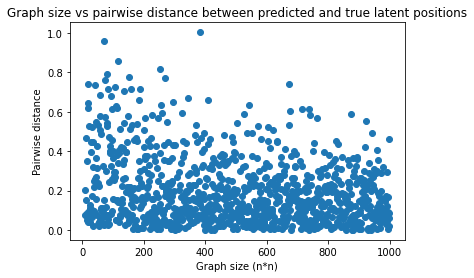

In [56]:
import matplotlib.pyplot as plt

# distances = sorted(distances.items()) # sorted by key, return a list of tuples
x, y = zip(*distances) # unpack a list of pairs into two tuples

# ended up being a shitty graph that doesn't say much
plt.scatter(x, y)
plt.title("Graph size vs pairwise distance between predicted and true latent positions");
plt.xlabel("Graph size (n*n)");
plt.ylabel("Pairwise distance");